# Neurotransmitters in plasma/brain

- using a QIIME2 2021.11 conda environment

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2 import Artifact, Visualization

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.diversity.beta import unweighted_unifrac
from skbio.stats import distance, ordination
from skbio import DistanceMatrix

from sklearn.decomposition import PCA

%matplotlib inline

## Read in data

### Metadata

In [36]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")
metadata.head()

,#SampleID,MetaboSampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
0,GT.063_N,18,2,B07,48,TTAACAAGGCAA,GTGYCAGCMGCCGCGGTAA,515rcbc222,63,Red,Green Tea,15.3,62.55,10/13/21,BSC,MK
1,GT.063_R,3,1,E01,49,TGATGTGCTAAG,GTGYCAGCMGCCGCGGTAA,515rcbc48,63,Red,Green Tea,39.9,51.15,10/13/21,BSC,MK
2,GT.066_B,17,2,A09,54,CCAGGACAGGAA,GTGYCAGCMGCCGCGGTAA,515rcbc200,66,Red,Green Tea,18.6,67.90,10/13/21,BSC,MK
3,GT.066_N,29,1,F12,55,AACTCAATAGCG,GTGYCAGCMGCCGCGGTAA,515rcbc167,66,Red,Green Tea,32.9,41.80,10/13/21,BSC,MK
4,GT.074_N,2,2,C12,52,GATATACCAGTG,GTGYCAGCMGCCGCGGTAA,515rcbc227,74,Red,Green Tea,9.8,38.75,10/13/21,BSC,MK


In [37]:
metadata = metadata.set_index("MetaboSampleID").sort_index()

### Plasma

In [38]:
plasma = pd.read_csv("../neurotransmitters/plasma_neurotransmitters.txt", 
                     sep="\t", index_col="SampleID")
plasma = plasma.rename(columns={"Unnamed: 2": "Time"})
plasma = plasma.sort_index()

### Brain

In [39]:
brain = pd.read_csv("../neurotransmitters/brain_neurotransmitters.txt",
                    sep="\t", index_col="SampleID")
brain = brain.sort_index()

### Microbiome

In [40]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

In [41]:
tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

In [42]:
microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

In [43]:
microbiome_index_mapper = metadata.reset_index().set_index("#SampleID")["MetaboSampleID"].to_dict()

new_microbiome_index = [int(microbiome_index_mapper[x]) for x in list(microbiome.index)]
microbiome.index = new_microbiome_index
microbiome = microbiome.sort_index()

## Analysis

### Neurotransmitter beta diversity

### PCA

In [44]:
plasma

,Sample,Time,Melatonin_pos,NAM,Pyridoxal and Isopyridoxal,Anthranilic Acid,Kynurenic acid,Metanephrine,3-hydroxy-athranilic acid (3-HAA),Serotonin,...,N-Formylkynurenine,Tryptophan,5-Hydroxyindole-3-acetic acid (5-HIAA),Glycyl-Phenylalanine,3-Hydroxy Kynurenine,Tyrosine,5-Hydroxytryptophan,Arginyl-Phenylalanine,GABA,NAD+
SampleID,,,,,,,,,,,,,,,,,,,,,
1,GF-2 July-PL.d,2/5/22 6:20,0.0000,1087.3600,0.0000,0.000,24.0600,0.0000,0.0000,609.6400,...,0.0000,51384.0300,0.0000,31.9800,0.0000,44795.050,0.0000,0.0000,76.5400,28.0500
10,GLD090-R-PL.d,2/5/22 2:14,0.0000,946.4000,0.0000,0.000,24.2200,0.0000,0.0000,3420.0800,...,12.4000,40574.6500,0.0000,0.0000,0.0000,23768.510,0.0000,0.0000,68.4200,26.9800
11,GLD113-R-PL.d,2/5/22 7:01,0.0000,456.1400,0.0000,0.000,8.1900,0.0000,0.0000,2674.6000,...,0.0000,40376.6300,0.0000,0.0000,0.0000,16758.400,0.0000,0.0000,63.2300,30.5500
12,GF-R Aug-PL.d,2/5/22 8:02,0.0000,324.6900,0.0000,0.000,3.8100,0.0000,0.0000,1799.2600,...,17.6600,50667.3700,0.0000,0.0000,0.0000,21993.940,0.0000,0.0000,49.0400,26.4000
13,GLD116-N-PL.d,2/5/22 7:42,0.0000,1108.6300,0.0000,0.000,16.7600,0.0000,0.0000,1565.8100,...,20.8900,39459.6600,0.0000,0.0000,0.0000,25671.040,0.0000,0.0000,58.6900,873.7300
14,GF-1 July-PL.d,2/5/22 3:36,0.0000,1048.3300,0.0000,0.000,22.4600,0.0000,0.0000,517.4800,...,32.1900,46919.8400,0.0000,0.0000,0.0000,43410.850,0.0000,0.0000,94.7700,101.5200
15,GLD101-R-PL.d,2/4/22 23:30,0.0000,293.3700,0.0000,0.000,7.2400,0.0000,0.0000,1792.5700,...,0.0000,45337.9600,0.0000,0.0000,0.0000,24867.690,0.0000,0.0000,78.7600,39.8100
16,GLD086-N-PL.d,2/5/22 4:17,0.0000,358.5200,0.0000,0.000,8.7200,0.0000,0.0000,299.8000,...,0.0000,51132.3700,0.0000,0.0000,0.0000,32910.850,0.0000,0.0000,44.0200,10.9600
17,GLD066-B-PL.d,2/5/22 6:40,4.4000,259.2300,253.8100,0.000,9.2500,0.0000,0.0000,134.2600,...,0.0000,30537.0700,0.0000,0.0000,0.0000,23590.100,0.0000,0.3800,67.3600,0.0000


In [45]:
plasma_pca = PCA(n_components=3)
plasma_pca_res = plasma_pca.fit_transform(plasma.drop(["Sample", "Time"],axis=1).drop("LLOQ (ng/ml)"))

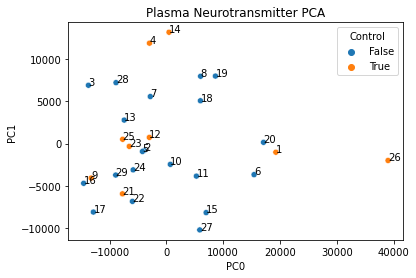

In [46]:
ax = sns.scatterplot(x=plasma_pca_res[:,0], y=plasma_pca_res[:,1],
                     hue=metadata["PID"]=="Control")
ax.set(xlabel="PC0", ylabel="PC1", title="Plasma Neurotransmitter PCA")
plt.legend(title="Control")

for i, name in enumerate(metadata.index):
    ax.text(x=plasma_pca_res[i,0],
            y=plasma_pca_res[i,1],
            s=name)

## What compounds are associated with microbiome composition?

In [47]:
plasma_samples = plasma.drop(["Sample", "Time"],axis=1).drop("LLOQ (ng/ml)")
brain_samples = brain.drop("Sample",axis=1).drop("LLOQ")
plasma_samples.index = [int(x) for x in plasma_samples.index]
brain_samples.index = [int(x) for x in brain_samples.index]

In [48]:
microbiome_u_uni = Artifact.load("../microbiome/core-metrics/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

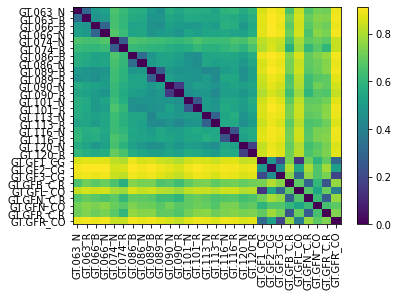

In [49]:
microbiome_u_uni

In [50]:
microbiome_u_uni_df = microbiome_u_uni.to_data_frame()

new_microbiome_u_uni_index = [int(microbiome_index_mapper[x]) for x in list(microbiome_u_uni_df.index)]
microbiome_u_uni_df.index = new_microbiome_u_uni_index
microbiome_u_uni_df = microbiome_u_uni_df.rename(index=microbiome_index_mapper, 
                                                 columns=microbiome_index_mapper)
microbiome_u_uni = DistanceMatrix(microbiome_u_uni_df, ids=microbiome_u_uni_df.index)

In [51]:
plasma_samples = plasma_samples.reindex(microbiome_u_uni_df.index)
brain_samples = brain_samples.reindex(microbiome_u_uni_df.index)

In [52]:
def make_euclidean_distance_matrix(data, ids):
    data = np.array(data)
    
    matrix_shape = (data.shape[0], data.shape[0])
    out_matrix = np.empty(matrix_shape)
    
    for i, entry in enumerate(data):
        for j, entry_2 in enumerate(data):
            if i==j:
                out_matrix[i,i] = 0
            elif i<j:
                diff = np.abs(entry_2 - entry)
                out_matrix[i,j] = diff
                out_matrix[j,i] = diff
                
            else:
                pass
    
    return DistanceMatrix(out_matrix, ids=ids)

### Plasma

In [53]:
plasma_index = [int(x) for x in plasma_samples.index]
plasma_mantel_results_u = pd.DataFrame(index=plasma_samples.columns,
                                            columns=["corr","p"])

for col in plasma_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(plasma_samples[col], 
                                                     ids=plasma_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson")
    
    plasma_mantel_results_u.loc[col,"corr"] = corr
    plasma_mantel_results_u.loc[col,"p"] = p
    
    print("\n================================")
    print(f"Mantel on {col} and unweighted UniFrac:")
    print(f"corr = {corr}, p = {p}")


Mantel on Melatonin_pos  and unweighted UniFrac:
corr = -0.06527616032849701, p = 0.459

Mantel on NAM  and unweighted UniFrac:
corr = 0.031948684093279646, p = 0.617

Mantel on Pyridoxal and Isopyridoxal  and unweighted UniFrac:
corr = -0.07159262799415557, p = 0.501

Mantel on Anthranilic Acid  and unweighted UniFrac:
corr = nan, p = nan


/Users/johnsterrett/mambaforge/envs/qiime2-2021.8/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Mantel on Kynurenic acid  and unweighted UniFrac:
corr = 0.18378117855841067, p = 0.03

Mantel on Metanephrine  and unweighted UniFrac:
corr = nan, p = nan

Mantel on 3-hydroxy-athranilic acid (3-HAA)  and unweighted UniFrac:
corr = nan, p = nan

Mantel on Serotonin  and unweighted UniFrac:
corr = -0.021014327113481855, p = 0.818

Mantel on Xanthurenic Acid  and unweighted UniFrac:
corr = 0.08789523327059566, p = 0.128

Mantel on Dopamine  and unweighted UniFrac:
corr = 0.09902669899286863, p = 0.134

Mantel on N-Methylnicotinamide  and unweighted UniFrac:
corr = 0.02336002374632577, p = 0.797

Mantel on Phenylalanine  and unweighted UniFrac:
corr = -0.025791061591218988, p = 0.743

Mantel on L-Kynurenine  and unweighted UniFrac:
corr = 0.0073782708532734755, p = 0.934

Mantel on Picolinic acid  and unweighted UniFrac:
corr = nan, p = nan

Mantel on N-Formylkynurenine  and unweighted UniFrac:
corr = -0.04768715647486607, p = 0.425

Mantel on Tryptophan  and unweighted UniFrac:
corr = 

In [54]:
plasma_mantel_results_u["Avg Abundance"] = plasma_samples.sum(axis=0)/plasma_samples.shape[0]
plasma_mantel_results_u["P<0.05"] = plasma_mantel_results_u["p"]<0.05
plasma_mantel_results_u["Log10 Avg Abundance"] = plasma_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

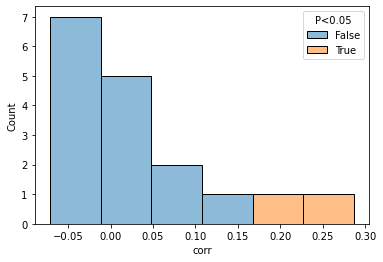

In [55]:
ax = sns.histplot(x = plasma_mantel_results_u["corr"], hue = plasma_mantel_results_u["P<0.05"])

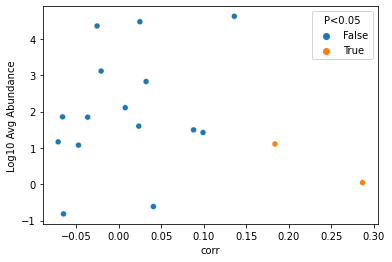

In [56]:
ax = sns.scatterplot(data=plasma_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [57]:
plasma_mantel_results_u[plasma_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Glycyl-Phenylalanine,0.286914,0.035,1.102759,True,0.042520
Kynurenic acid,0.183781,0.03,12.796897,True,1.107108


In [58]:
plasma_mantel_results_u[plasma_mantel_results_u["P<0.05"]].sort_values("Avg Abundance")

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Glycyl-Phenylalanine,0.286914,0.035,1.102759,True,0.042520
Kynurenic acid,0.183781,0.03,12.796897,True,1.107108


In [59]:
plasma_mantel_results_u

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Melatonin_pos,-0.065276,0.459,0.151724,False,-0.818659
NAM,0.031949,0.617,670.189655,False,2.826198
Pyridoxal and Isopyridoxal,-0.071593,0.501,14.624138,False,1.165073
Anthranilic Acid,NaN,NaN,0.000000,False,-4.000000
Kynurenic acid,0.183781,0.03,12.796897,True,1.107108
Metanephrine,NaN,NaN,0.000000,False,-4.000000
3-hydroxy-athranilic acid (3-HAA),NaN,NaN,0.000000,False,-4.000000
Serotonin,-0.021014,0.818,1304.633103,False,3.115488
Xanthurenic Acid,0.087895,0.128,31.214828,False,1.494362
Dopamine,0.099027,0.134,26.449655,False,1.422422


In [60]:
def prep_sig_table(df, rounding_dict):
    
    df_copy = df.copy()

    # prep compound names
    names = df_copy.index
    names = list(map(lambda x: x.split(" - ")[0], names))
    names = list(map(lambda x: x.split("_")[0], names))
    df_copy.index = names

    for col, digits in rounding_dict.items():
        df_copy.loc[:,col] = df_copy.loc[:,col].apply(lambda x: round(x, digits))

    return df_copy


In [61]:
prep_sig_table(plasma_mantel_results_u, 
               {"corr": 2,
                "p": 3,
                "Avg Abundance": 2}
                ).sort_values(by="p").loc[:,["corr", "p", "Avg Abundance"]].to_csv("plasma_mantel_results_u.csv")

prep_sig_table(plasma_mantel_results_u, 
               {"corr": 2,
                "p": 3,
                "Avg Abundance": 2}
                ).sort_values(by="p").loc[:,["corr", "p", "Avg Abundance"]]

,corr,p,Avg Abundance
Kynurenic acid,0.18,0.030,12.80
Glycyl-Phenylalanine,0.29,0.035,1.10
Tryptophan,0.14,0.057,42035.60
Xanthurenic Acid,0.09,0.128,31.21
Dopamine,0.10,0.134,26.45
GABA,-0.07,0.345,71.34
N-Formylkynurenine,-0.05,0.425,11.89
Melatonin,-0.07,0.459,0.15
Pyridoxal and Isopyridoxal,-0.07,0.501,14.62
NAM,0.03,0.617,670.19


### Brain

In [62]:
brain_samples_index = [int(x) for x in brain_samples.index]
brain_mantel_results_u = pd.DataFrame(index=brain_samples.columns,
                                            columns=["corr","p"])

for col in brain_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(brain_samples[col], 
                                                     ids=brain_samples_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson")
    
    brain_mantel_results_u.loc[col,"corr"] = corr
    brain_mantel_results_u.loc[col,"p"] = p

/Users/johnsterrett/mambaforge/envs/qiime2-2021.8/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [63]:
brain_mantel_results_u["Avg Abundance"] = brain_samples.sum(axis=0)/brain_samples.shape[0]
brain_mantel_results_u["P<0.05"] = brain_mantel_results_u["p"]<0.05
brain_mantel_results_u["Log10 Avg Abundance"] = brain_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

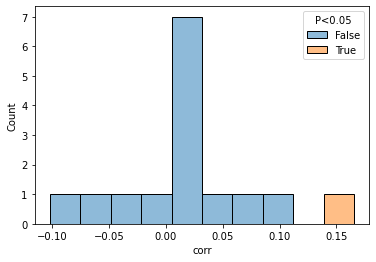

In [64]:
ax = sns.histplot(x = brain_mantel_results_u["corr"], hue = brain_mantel_results_u["P<0.05"])

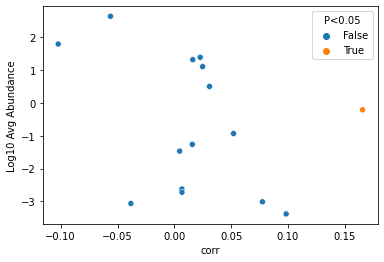

In [65]:
ax = sns.scatterplot(data=brain_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [66]:
brain_mantel_results_u[brain_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False).head(20)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Dopamine,0.165621,0.039,0.616448,True,-0.210033


In [67]:
prep_sig_table(brain_mantel_results_u, 
               {"corr": 2,
                "p": 3,
                "Avg Abundance": 2}
                ).sort_values(by="p").loc[:,["corr", "p", "Avg Abundance"]].to_csv("brain_mantel_results_u.csv")

prep_sig_table(brain_mantel_results_u, 
               {"corr": 2,
                "p": 3,
                "Avg Abundance": 2}
                ).sort_values(by="p").loc[:,["corr", "p", "Avg Abundance"]]

,corr,p,Avg Abundance
Dopamine,0.17,0.039,0.62
NAM,-0.10,0.175,62.20
Melatonin,0.10,0.289,0.00
Kynurenic acid,0.08,0.443,0.00
Serotonin,0.05,0.490,0.12
GABA,-0.06,0.519,436.56
Pyridoxal and Isopyridoxal,-0.04,0.738,0.00
NAD+,0.03,0.743,3.18
Tryptophan,0.02,0.866,12.76
Tyrosine,0.02,0.870,24.56


## Figure of neurotransmitters

In [31]:
microbiome_pcoa_u_uni = ordination.pcoa(microbiome_u_uni, number_of_dimensions=3)

/Users/johnsterrett/mambaforge/envs/qiime2-2021.8/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.009383724064282497 and the largest is 2.3841342781282275.
  warn(


In [32]:
brain_samples.columns

Index(['Melatonin_pos  ', 'NAM  ', 'Pyridoxal and Isopyridoxal  ',
       'Anthranilic Acid  ', 'Kynurenic acid  ', 'Metanephrine  ',
       '3-hydroxy-athranilic acid (3-HAA)  ', 'Serotonin  ',
       'Xanthurenic Acid  ', 'Dopamine  ', 'N-Methylnicotinamide  ',
       'Phenylalanine  ', 'L-Kynurenine  ', 'Picolinic acid  ',
       'N-Formylkynurenine  ', 'Tryptophan  ',
       '5-Hydroxyindole-3-acetic acid (5-HIAA)  ', 'Glycyl-Phenylalanine  ',
       '3-Hydroxy Kynurenine  ', 'Tyrosine  ', '5-Hydroxytryptophan  ',
       'Arginyl-Phenylalanine  ', 'GABA  ', 'NAD+  '],
      dtype='object')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

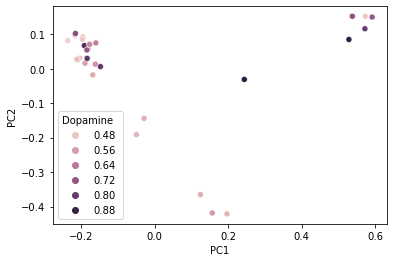

In [33]:
sns.scatterplot(x="PC1", y="PC2",
                hue=brain_samples["Dopamine  "],
               data=microbiome_pcoa_u_uni.samples)

<AxesSubplot:xlabel='PC2', ylabel='Dopamine '>

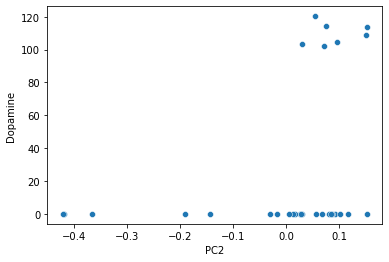

In [34]:
sns.scatterplot(x=microbiome_pcoa_u_uni.samples["PC2"], y=plasma_samples["Dopamine "])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

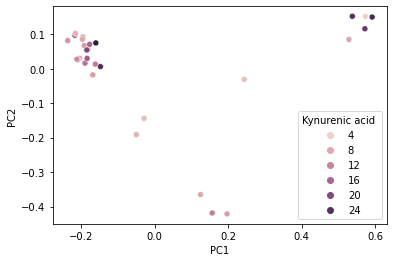

In [35]:
sns.scatterplot(x="PC1", y="PC2",
                hue=plasma_samples["Kynurenic acid "],
               data=microbiome_pcoa_u_uni.samples)

<AxesSubplot:xlabel='PC2', ylabel='Kynurenic acid '>

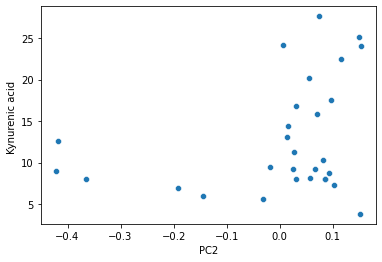

In [36]:
sns.scatterplot(x=microbiome_pcoa_u_uni.samples["PC2"], y=plasma_samples["Kynurenic acid "])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

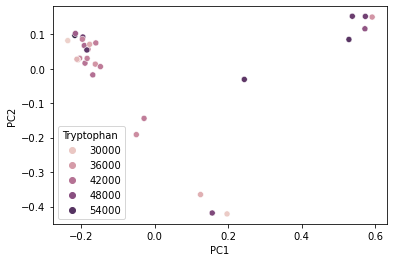

In [37]:
sns.scatterplot(x="PC1", y="PC2",
                hue=plasma_samples["Tryptophan "],
               data=microbiome_pcoa_u_uni.samples)

<AxesSubplot:xlabel='PC1', ylabel='Tryptophan '>

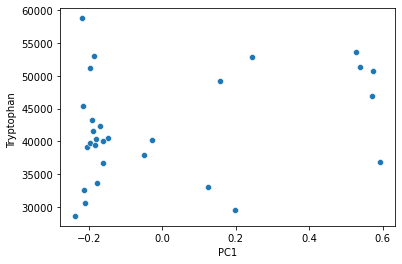

In [38]:
sns.scatterplot(x=microbiome_pcoa_u_uni.samples["PC1"], y=plasma_samples["Tryptophan "])

In [39]:
metadata = metadata.reindex(plasma_samples.index)

<AxesSubplot:xlabel='PID', ylabel='Tryptophan '>

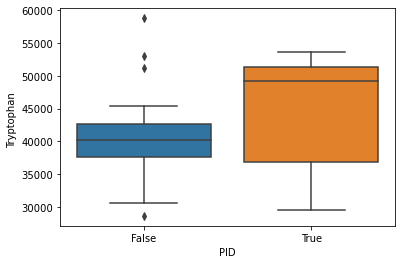

In [40]:
sns.boxplot(x=metadata["PID"]=="Control", y=plasma_samples["Tryptophan "])

<AxesSubplot:xlabel='PID', ylabel='Kynurenic acid '>

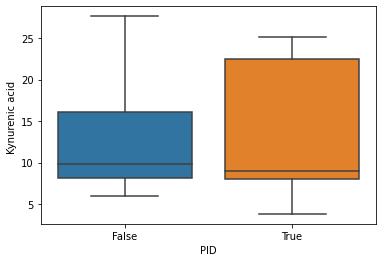

In [41]:
sns.boxplot(x=metadata["PID"]=="Control", y=plasma_samples["Kynurenic acid "])

<AxesSubplot:xlabel='PID', ylabel='Dopamine  '>

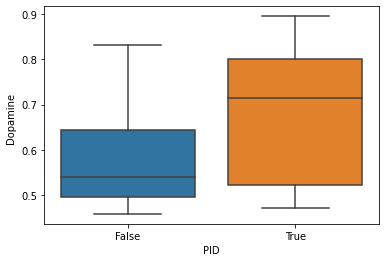

In [66]:
sns.boxplot(x=metadata["PID"]=="Control", y=brain_samples["Dopamine  "])